In [2112]:
import pandas as pd
import geopandas as gpd

In [2113]:
from constants import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2114]:
df_train = pd.read_csv(PATH_DF_TRAIN)
df_test = pd.read_csv(PATH_DF_TEST)

In [2115]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18850 entries, 0 to 18849
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18850 non-null  int64  
 1   id                        18850 non-null  object 
 2   start_date                18850 non-null  object 
 3   end_date                  18850 non-null  object 
 4   created_on                18850 non-null  object 
 5   latitud                   18133 non-null  float64
 6   longitud                  18133 non-null  float64
 7   place_l2                  18850 non-null  object 
 8   place_l3                  18755 non-null  object 
 9   place_l4                  740 non-null    object 
 10  place_l5                  0 non-null      float64
 11  place_l6                  0 non-null      float64
 12  operation                 18850 non-null  object 
 13  property_type             18850 non-null  object 
 14  proper

Hacemos el mismo "tratamiento" al df_test que el que ya le hicimos al df_train

In [2116]:
df_test.drop(columns=["id", "start_date", "end_date", "created_on", "place_l2", "place_l4", "place_l5", "place_l6", "operation", "property_currency", "property_title"], inplace=True)

In [2117]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18850 entries, 0 to 18849
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18850 non-null  int64  
 1   latitud                   18133 non-null  float64
 2   longitud                  18133 non-null  float64
 3   place_l3                  18755 non-null  object 
 4   property_type             18850 non-null  object 
 5   property_rooms            18650 non-null  float64
 6   property_bedrooms         16594 non-null  float64
 7   property_surface_total    17860 non-null  float64
 8   property_surface_covered  18158 non-null  float64
 9   property_price            18850 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 1.4+ MB


In [2118]:
df_test.head(3)

,Unnamed: 0,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,446819,-34.600813,-58.497620,Villa del Parque,Departamento,1.0,NaN,45.0,41.0,130000.0
1,135148,-34.556298,-58.439923,Belgrano,Departamento,5.0,3.0,175.0,141.0,579000.0
2,445316,-34.612908,-58.386174,Congreso,Departamento,1.0,NaN,25.0,NaN,49000.0


Veo que la columna unnamed es la indicadora de la fila del csv, la borramos

In [2119]:
df_test.drop(columns=["Unnamed: 0"], inplace=True)

In [2120]:
df_test.head(3)

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.600813,-58.497620,Villa del Parque,Departamento,1.0,NaN,45.0,41.0,130000.0
1,-34.556298,-58.439923,Belgrano,Departamento,5.0,3.0,175.0,141.0,579000.0
2,-34.612908,-58.386174,Congreso,Departamento,1.0,NaN,25.0,NaN,49000.0


In [2121]:
df_test[(df_test["property_bedrooms"].isnull()) & (df_test["property_rooms"].isnull())].shape

(81, 9)

In [2122]:
df_test[(df_test["property_bedrooms"].notnull()) & (df_test["property_rooms"].isnull())].shape

(119, 9)

In [2123]:
df_test[(df_test["property_bedrooms"].isnull()) & (df_test["property_rooms"].notnull())].shape

(2175, 9)

In [2124]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df_test.dropna(subset=["property_bedrooms", "property_rooms"], inplace=True)

#2. Imputar la cantidad de habitaciones como cantidad de ambientes - 1
df_test["property_bedrooms"].fillna(df_test["property_rooms"] - 1, inplace=True)

#3. Imputar la cantidad de ambientes como cantidad de habitaciones + 1
df_test["property_rooms"].fillna(df_test["property_bedrooms"] + 1, inplace=True)

/tmp/ipykernel_8633/1460161699.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["property_bedrooms"].fillna(df_test["property_rooms"] - 1, inplace=True)
/tmp/ipykernel_8633/1460161699.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

In [2125]:
df_test.isnull().sum()

latitud                     605
longitud                    605
place_l3                     48
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total      826
property_surface_covered    548
property_price                0
dtype: int64

In [2126]:
df_test[(df_test["property_surface_covered"].isnull()) & (df_test["property_surface_total"].isnull())].shape

(0, 9)

In [2127]:
df_test[(df_test["property_surface_covered"].notnull()) & (df_test["property_surface_total"].isnull())].shape

(826, 9)

In [2128]:
df_test[(df_test["property_surface_covered"].isnull()) & (df_test["property_surface_total"].notnull())].shape

(548, 9)

In [2129]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df_test.dropna(subset=["property_surface_covered", "property_surface_total"], inplace=True)

#2. Imputar la superficie cubierta como superficie total
df_test["property_surface_covered"].fillna(df_test["property_surface_total"], inplace=True)

#3. Imputar superficie total como superficie cubierta
df_test["property_surface_total"].fillna(df_test["property_surface_covered"], inplace=True)

/tmp/ipykernel_8633/1190692529.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test["property_surface_covered"].fillna(df_test["property_surface_total"], inplace=True)
/tmp/ipykernel_8633/1190692529.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

In [2130]:
df_test[df_test["property_price"] <= 0].shape

(0, 9)

In [2131]:
df_test[df_test["property_surface_covered"] <= 0].shape

(0, 9)

In [2132]:
df_test[df_test["property_surface_total"] <= 0].shape

(0, 9)

In [2133]:
df_test[df_test["property_surface_total"] < df_test["property_surface_covered"]].shape

(31, 9)

In [2134]:
filas_erroneas = df_test["property_surface_total"] < df_test["property_surface_covered"]

In [2135]:
df_test.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df_test.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values

In [2136]:
mediana = df_test["property_surface_total"].median()

limite_superior = mediana * 7

df_test = df_test[df_test["property_surface_total"] <= limite_superior]

In [2137]:
df_test.isnull().sum()

latitud                     539
longitud                    539
place_l3                     36
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total        0
property_surface_covered      0
property_price                0
dtype: int64

In [2138]:
df_test[(df_test["latitud"].isnull()) & (df_test["longitud"].isnull())].shape

(539, 9)

In [2139]:
# aca habria que hacer lo que hice antes en la primera entrega (q se borro o no se q paso xd), 
# si en property_title tengo un barrio, lo pongo como place_l3.

In [2140]:
df_test.dropna(subset=["latitud", "longitud", "place_l3"], inplace=True)

In [2141]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55059 entries, 0 to 55058
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                55059 non-null  int64  
 1   latitud                   55059 non-null  float64
 2   longitud                  55059 non-null  float64
 3   property_rooms            55059 non-null  float64
 4   property_bedrooms         55059 non-null  float64
 5   property_surface_total    55059 non-null  float64
 6   property_surface_covered  55059 non-null  float64
 7   property_price            55059 non-null  float64
 8   total_m2_price            55059 non-null  float64
 9   covered_m2_price          55059 non-null  float64
 10  Casa                      55059 non-null  int64  
 11  Departamento              55059 non-null  int64  
 12  PH                        55059 non-null  int64  
 13  Palermo                   55059 non-null  int64  
 14  Belgra

In [2142]:
df_train.drop(columns=["Unnamed: 0"], inplace=True)

In [2143]:
df_test["total_m2_price"] = df_test["property_price"] / df_test["property_surface_total"]
df_test["covered_m2_price"] = df_test["property_price"] / df_test["property_surface_covered"]

In [2144]:
df_test = pd.get_dummies(df_test, columns=["property_type"])
df_test.rename(columns={"property_type_Casa": "Casa", "property_type_Departamento": "Departamento", "property_type_PH": "PH"}, inplace=True)
df_test["Casa"] = df_test["Casa"].astype(int)
df_test["Departamento"] = df_test["Departamento"].astype(int)
df_test["PH"] = df_test["PH"].astype(int)

In [2145]:
top_3_barrios = df_test["place_l3"].value_counts().nlargest(3).index.tolist()

for value in top_3_barrios:
    df_test[value] = (df_test["place_l3"] == value).astype(int)

df_test["Otro barrio"] = (~(df_test["place_l3"].isin(top_3_barrios))).astype(int)

df_test.drop(columns=["place_l3"], inplace=True)

In [2146]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14433 entries, 1 to 18849
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   14433 non-null  float64
 1   longitud                  14433 non-null  float64
 2   property_rooms            14433 non-null  float64
 3   property_bedrooms         14433 non-null  float64
 4   property_surface_total    14433 non-null  float64
 5   property_surface_covered  14433 non-null  float64
 6   property_price            14433 non-null  float64
 7   total_m2_price            14433 non-null  float64
 8   covered_m2_price          14433 non-null  float64
 9   Casa                      14433 non-null  int64  
 10  Departamento              14433 non-null  int64  
 11  PH                        14433 non-null  int64  
 12  Palermo                   14433 non-null  int64  
 13  Belgrano                  14433 non-null  int64  
 14  Caballito  

## Construcción del target para clasificar

## Modelos clasificación

In [2147]:
df = pd.concat([df_train, df_test])

In [2148]:
df_train.columns, df_test.columns

(Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
        'property_surface_total', 'property_surface_covered', 'property_price',
        'total_m2_price', 'covered_m2_price', 'Casa', 'Departamento', 'PH',
        'Palermo', 'Belgrano', 'Caballito', 'Otro barrio'],
       dtype='object'),
 Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
        'property_surface_total', 'property_surface_covered', 'property_price',
        'total_m2_price', 'covered_m2_price', 'Casa', 'Departamento', 'PH',
        'Palermo', 'Belgrano', 'Caballito', 'Otro barrio'],
       dtype='object'))

In [2149]:
tope_bajo = df_train["total_m2_price"].quantile(1/3)
piso_alto = df_train["total_m2_price"].quantile(2/3)

labels = [0, 1, 2]

df_train["tipo_precio"] = pd.cut(df_train["total_m2_price"], bins=[-float('inf'), tope_bajo, piso_alto, float('inf')], labels=labels, include_lowest=True)

df_train["tipo_precio"] = df_train["tipo_precio"].astype(int)

In [2150]:
df_train.head(2)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,total_m2_price,covered_m2_price,Casa,Departamento,PH,Palermo,Belgrano,Caballito,Otro barrio,tipo_precio
0,-34.598103,-58.442806,1.0,1.0,30.0,27.0,79000.0,2633.333333,2925.925926,0,1,0,0,0,0,1,2
1,-34.583233,-58.403942,4.0,3.0,200.0,200.0,790000.0,3950.000000,3950.000000,0,1,0,1,0,0,0,2


Text(0, 0.5, 'Cantidad de registros')

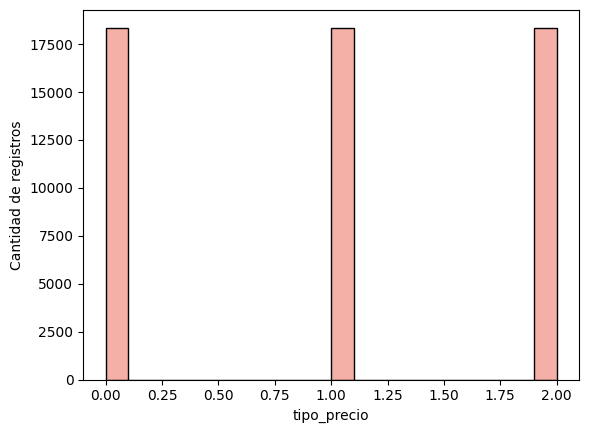

In [2151]:
sns.histplot(df_train["tipo_precio"], color=CORAL)
plt.ylabel("Cantidad de registros")

In [2152]:
df_train.drop(columns=["tipo_precio"], inplace=True)

In [2153]:
# Alternativa cuartil

primer_cuartil = df["total_m2_price"].quantile(0.25)
tercer_cuartil = df["total_m2_price"].quantile(0.75)
intervalos = [0, primer_cuartil, tercer_cuartil, float("inf")] 

labels = [0, 1, 2]

df["tipo_precio"] = pd.cut(df["total_m2_price"], bins=[-float('inf'), primer_cuartil, tercer_cuartil, float('inf')], labels=labels, include_lowest=True)

df["tipo_precio"] = df["tipo_precio"].astype(int)

Text(0, 0.5, 'Cantidad de registros')

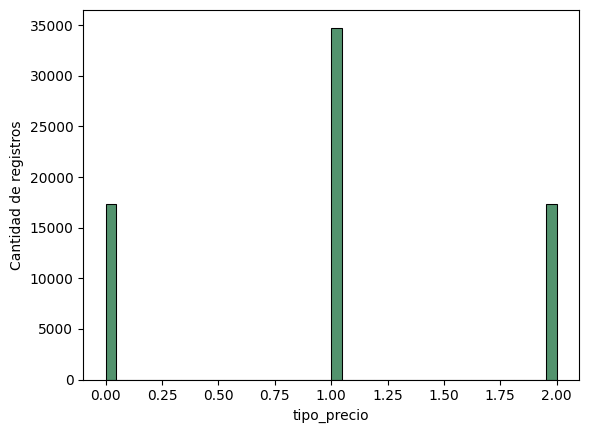

In [2154]:
sns.histplot(df["tipo_precio"], color=VERDE)
plt.ylabel("Cantidad de registros")

In [2155]:
df["tipo_precio"].value_counts()

tipo_precio
1    34767
0    17386
2    17339
Name: count, dtype: int64

In [2156]:
def calcular_tipo(grupo):
    primer_cuartil = grupo.quantile(0.25)
    tercer_cuartil = grupo.quantile(0.75)
    result = pd.Series(index=grupo.index)
    result[grupo <= primer_cuartil] = 0
    result[(grupo > primer_cuartil) & (grupo <= tercer_cuartil)] = 1
    result[grupo > tercer_cuartil] = 2
    return result

grouped = df_train.groupby(["Casa", "Departamento", "PH"])["total_m2_price"]
df_train["tipo_precio"] = grouped.apply(calcular_tipo).reset_index(drop=True)


Text(0, 0.5, 'Cantidad de registros')

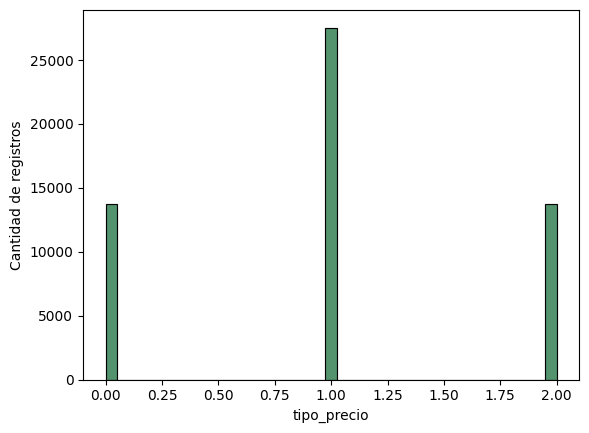

In [2157]:
sns.histplot(df_train["tipo_precio"], color=VERDE)
plt.ylabel("Cantidad de registros")

In [2158]:
df_train["tipo_precio"].value_counts()

tipo_precio
1.0    27540
0.0    13771
2.0    13748
Name: count, dtype: int64

Nos quedamos con la última forma de clasificación porque creemos que es la más certera por su (no me sale la palabra pero basicamente que es más específica la búsqueda)

In [2159]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123) # me tira error con la constante

Text(0, 0.5, 'Cantidad de registros')

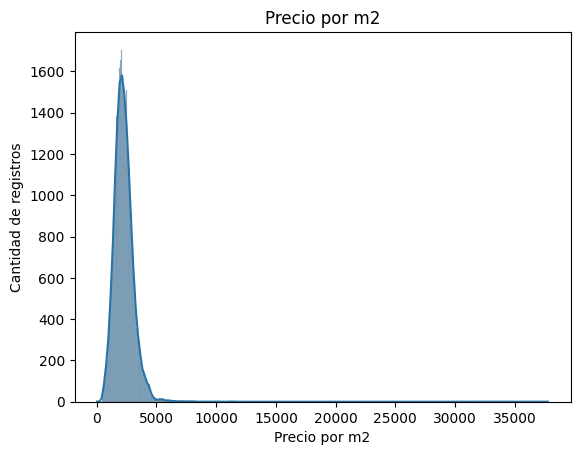

In [2160]:
sns.histplot(df_train["total_m2_price"], kde=True, color=AZUL)
plt.title("Precio por m2")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

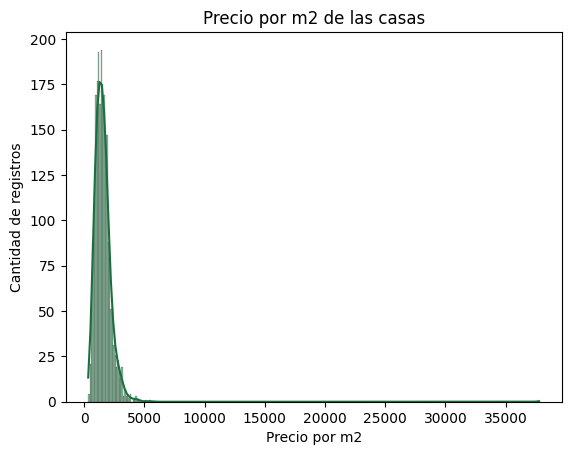

In [2161]:
sns.histplot(df_train[df_train["Casa"] == 1]["total_m2_price"], kde=True, color=VERDE)
plt.title("Precio por m2 de las casas")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

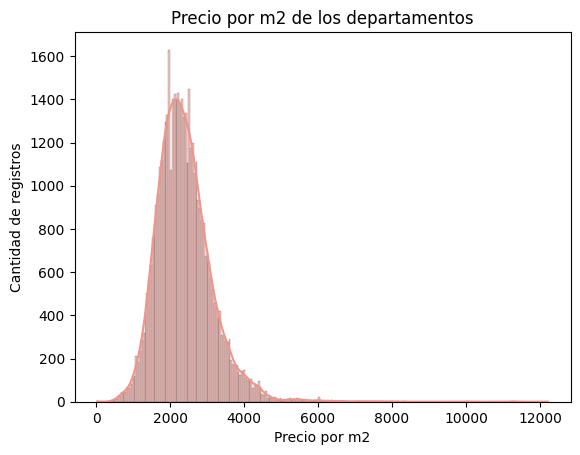

In [2162]:
sns.histplot(df_train[df_train["Departamento"] == 1]["total_m2_price"], kde=True, color=CORAL)
plt.title("Precio por m2 de los departamentos")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

Text(0, 0.5, 'Cantidad de registros')

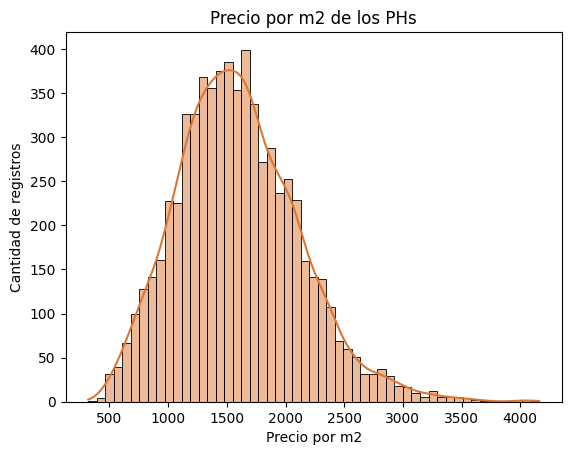

In [2163]:
sns.histplot(df_train[df_train["PH"] == 1]["total_m2_price"], kde=True, color=NARANJA)
plt.title("Precio por m2 de los PHs")
plt.xlabel("Precio por m2")
plt.ylabel("Cantidad de registros")

In [2164]:
barrios_caba = gpd.read_file("barrios.geojson")
p = gpd.GeoSeries(barrios_caba.geometry)

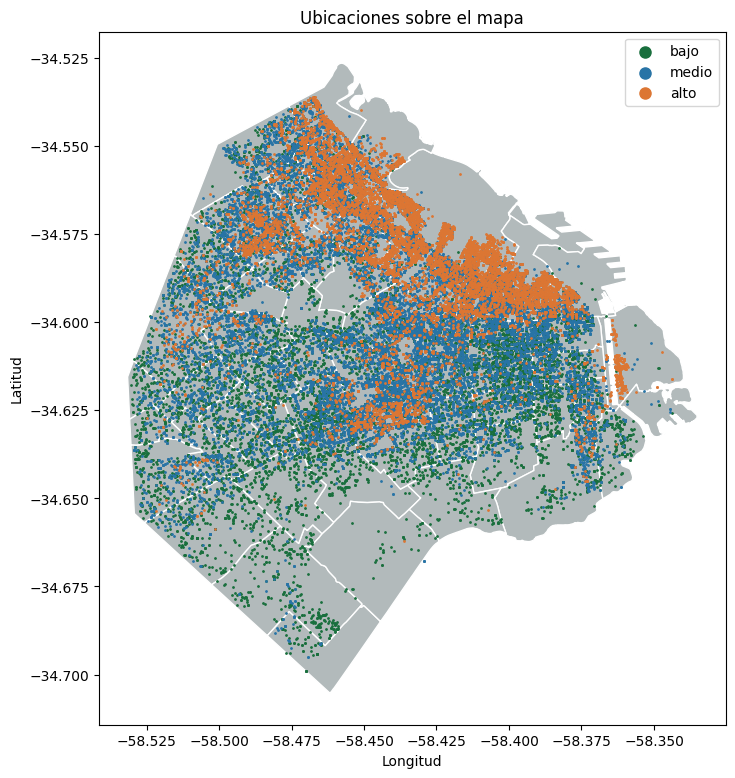

In [2165]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

colores = COLORES[:3] 
rangos = ["bajo", "medio", "alto"]

for i in range(3):
    plt.scatter(df_train[df_train["tipo_precio"] == i]["longitud"], df_train[df_train["tipo_precio"] == i]["latitud"], s = 1, c = colores[i], label = rangos[i])

plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale = 8)
plt.show()

el 3.a.e ????? no entendi la consigna xd

In [2166]:
x_train = df_train.drop(columns=["tipo_precio"])
y_train = df_train["tipo_precio"]
x_test = df_test.drop(columns=["tipo_precio"])
y_test = df_test["tipo_precio"]

### 1. Árbol de decisión

### 2. Random Forest

In [2167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [2168]:
rf =  RandomForestClassifier(random_state=1)

parametros = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10, 20, 50] }


rscv = RandomizedSearchCV(estimator = rf,
                              param_distributions = parametros,
                              scoring = "accuracy",
                              cv = 5,
                              n_jobs = -1,
                              n_iter = 5,
                              random_state=123) 

rscv.fit(x_train, y_train)

print(rscv.best_score_)

0.9999640239240177


In [2169]:
# XD

In [2170]:
rf = RandomForestClassifier(random_state=231).set_params(**rscv.best_params_)

#Entrenamos el modelo
rf.fit(X = x_train, y = y_train)

#Realizamos una predicción sobre el set de test
y_predicted = rf.predict(x_test)

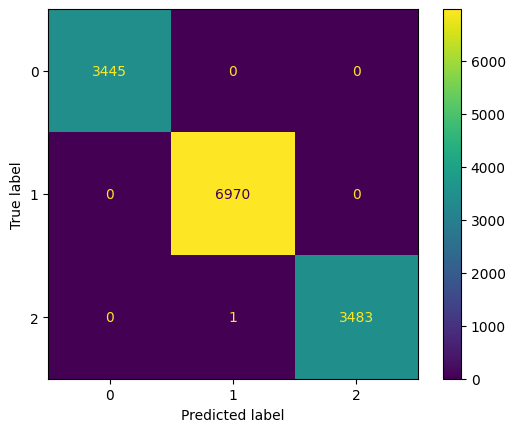

In [2171]:
cm = confusion_matrix(y_test, y_predicted)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [2172]:
# todos son 1 XD

## Modelos regresión

### 1. KNN

In [2173]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55593 entries, 28934 to 15725
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   55593 non-null  float64
 1   longitud                  55593 non-null  float64
 2   property_rooms            55593 non-null  float64
 3   property_bedrooms         55593 non-null  float64
 4   property_surface_total    55593 non-null  float64
 5   property_surface_covered  55593 non-null  float64
 6   property_price            55593 non-null  float64
 7   total_m2_price            55593 non-null  float64
 8   covered_m2_price          55593 non-null  float64
 9   Casa                      55593 non-null  int64  
 10  Departamento              55593 non-null  int64  
 11  PH                        55593 non-null  int64  
 12  Palermo                   55593 non-null  int64  
 13  Belgrano                  55593 non-null  int64  
 14  Caballi

In [2174]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score

In [2175]:
x_train = df_train.drop(columns=["property_price", "total_m2_price", "covered_m2_price"])
x_test = df_test.drop(columns=["property_price", "total_m2_price", "covered_m2_price"])
y_train = df_train["property_price"]
y_test = df_test["property_price"]

In [2176]:
# from sklearn.model_selection import RandomizedSearchCV

# #Grilla de Parámetros
# params = { "n_neighbors":range(1, 30), 
#               "weights":["distance","uniform"],
#               "algorithm":["ball_tree", "kd_tree", "brute"],
#               "metric":["euclidean","manhattan","chebyshev"]
#              }

# #Clasificador KNN
# knn = KNeighborsRegressor()

# #Random Search con 10 Folds y 10 iteraciones
# rand = RandomizedSearchCV(knn, param_distributions=params, n_iter=10, cv=5, random_state=42)

# rand.fit(x_train, y_train)

In [2177]:
# # Creo un modelo KNN para regresion y lo ajusto
# knn_regressor = knn.set_params(**rand.best_params_).fit(x_train, y_train)

# #Hago una predicción
# y_pred = knn_regressor.predict(x_test)

In [2178]:
# r2_score_knn = r2_score(y_test.values, y_pred)
# r2_score_knn

### 2. XGBoost